In [2]:

import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nue as nue
from tqdm import tqdm
import importlib
____ = importlib.reload(nue)
nue.signal_dict = {"nueCC":0,"numuCC":1,"nuNC":2,"nuOther":3,"dirt":4,"cosmic":5}

## some notes: 

Some preparation of the samples has already been done in a separate script (`combine_trees.py`). These samples are using the re-trained BDTs (CRUMBS and Razzled) that are only available on Henry Lay's feature branch `feature/hlay_pizero`. To make his samples compatible with my current analysis workflow, I combined the existing hdf5 files with the `hists` files from Henry's analysis module (again, more details can be seen in `combine_trees.py`). 

- this selection now includes contributions from in-time cosmics, with the proper scaling (I'm pretty sure at least)
- this selection utilizes a intrnue sample + rockbox/bnb sample to get higher signal numbers.
- by the end of the selection, the number of background becomes very statistically limited. Should generate a larger background sample, take the purity calculations with a big grain of salt. 
    - some error bars have been added to the purity plots, they are using counting error (instead of binomial error), so they are more of an estimate. 

## prepare the samples!

In [3]:
nu_idx_set = ["ntuple","entry","nu_index"]
slc_idx_set = ["ntuple","entry","rec.slc__index"]

In [32]:
nue_nu_df            = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df/ana_intrnue_nu.pkl")
slcpfp_nue_nu_df     = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df/ana_intrnue_slcpfp_nu.pkl").     query("signal==0")
slc_ro_nue_nu_df     = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df/ana_intrnue_slcpfp_opt_raz.pkl").query("signal==0").sort_values("entry")

print("percentage of noncos slc w/ opt0 info: ", round(100*len(nue.get_slc(slc_ro_nue_nu_df).query("(slc_is_clear_cosmic==0)&(score==score)"))/len(nue.get_slc(slc_ro_nue_nu_df).query("slc_is_clear_cosmic==0")),2))
print("percentage of noncos pfp w/ razzled info: ", round(100*len(slc_ro_nue_nu_df.query("(slc_is_clear_cosmic==0)&(slc_pfp_razzled_pdg==slc_pfp_razzled_pdg)"))/len(slc_ro_nue_nu_df.query("slc_is_clear_cosmic==0")),2))

# dups fix because i'm dumb.. accidentally included multiple opt0 matches
slc_ro_nue_nu_df = slc_ro_nue_nu_df[(slc_ro_nue_nu_df.score == slc_ro_nue_nu_df.groupby(["run","subrun","event","slc_self"])["score"].transform(max)) | (slc_ro_nue_nu_df.score.isna()==True)]
slc_ro_nue_nu_df["frac_pe"] = (slc_ro_nue_nu_df.hypo_pe - slc_ro_nue_nu_df.flash_pe)/slc_ro_nue_nu_df.flash_pe

percentage of noncos slc w/ opt0 info:  98.42
percentage of noncos pfp w/ razzled info:  94.23


In [35]:
# this cell will take ~1 min on the build server 
bnb_nu_df            = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df/ana_rockbox_nu.pkl")
slcpfp_bnb_nu_df     = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df/ana_rockbox_slcpfp_nu.pkl")
slc_ro_bnb_nu_df     = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df/ana_rockbox_slcpfp_opt_raz.pkl").sort_values("entry")

print("percentage of noncos slc w/ opt0 info: ", round(100*len(nue.get_slc(slc_ro_bnb_nu_df).query("(slc_is_clear_cosmic==0)&(score==score)"))/len(nue.get_slc(slc_ro_bnb_nu_df).query("slc_is_clear_cosmic==0")),2))
print("percentage of noncos pfp w/ razzled info: ", round(100*len(slc_ro_bnb_nu_df.query("(slc_is_clear_cosmic==0)&(slc_pfp_razzled_pdg==slc_pfp_razzled_pdg)"))/len(slc_ro_bnb_nu_df.query("slc_is_clear_cosmic==0")),2))

# opt0 duplicate fix because i'm stupid
slc_ro_bnb_nu_df = slc_ro_bnb_nu_df[(slc_ro_bnb_nu_df.score == slc_ro_bnb_nu_df.groupby(["run","subrun","event","slc_self"])["score"].transform(max)) | (slc_ro_bnb_nu_df.score.isna()==True)]
slc_ro_bnb_nu_df["frac_pe"] = (slc_ro_bnb_nu_df.hypo_pe - slc_ro_bnb_nu_df.flash_pe)/slc_ro_bnb_nu_df.flash_pe

percentage of noncos slc w/ opt0 info:  84.94
percentage of noncos pfp w/ razzled info:  93.52


In [6]:
# this cell will take ~1 min on the build server 
# this cell fixes an issue with not accounting nue slices that we drop the truth information for in the rockbox sample.
slc_ro_bnb_nu_idx = (slc_ro_bnb_nu_df.set_index(nu_idx_set).sort_index()
                     .drop(columns=['prim_start_x', 'prim_start_y', 'prim_start_z', 'prim_end_x',
                                    'prim_end_y', 'prim_end_z', 'pind', 'signal', 'total_prim_depE',
                                    'nelec', 'nmuon', 'ngamma', 'npi0', 'npi', 'nneu', 'nproton', 'nother',
                                    'prim_exit_count', 'prim_cont','rec.mc.nu__index', 'E', 'position_x', 'position_y', 'position_z',
                                    'pdg', 'iscc', 'genie_mode', 'nprim', 'ind', 'prim_pdg', 'prim_startE',
                                    'prim_endE', 'prim_startp_x', 'prim_startp_y', 'prim_startp_z']))
bnb_nu_idx        = bnb_nu_df.set_index(nu_idx_set).sort_index()
test_slc_df       = slc_ro_bnb_nu_idx.join(bnb_nu_idx,how="left")

test_slc_df = test_slc_df.query("signal!=0")
test_slc_df["signal"] = np.where(test_slc_df.slc_tmatch_idx<0, 5, test_slc_df.signal)
slc_ro_bnb_nu_df = test_slc_df.reset_index().copy()

In [34]:
# intime cosmics sample
int_file = "/sbnd/data/users/lynnt/v09_75_03_03/intime.df"
int_hdr_df_0 = pd.read_hdf(int_file,key="hdr")
slc_ro_int_df = pd.read_pickle("/sbnd/data/users/lynnt/v09_75_03_03/df/ana_intime_slcpfp_opt_raz.pkl").sort_values("entry")

In [9]:
# scale intime cosmics by # of generated events
bnb_file = "/sbnd/data/users/lynnt/v09_75_03_03/rockbox.df"
bnb_hdr_df_0 = pd.read_hdf(bnb_file,key="hdr")
bnb_genevt = np.sum(nue.flatten_df(bnb_hdr_df_0).drop_duplicates(subset=["ntuple","rec_hdr_subrun"]).rec_hdr_ngenevt)
int_genevt = np.sum(nue.flatten_df(int_hdr_df_0).drop_duplicates(subset=["ntuple","rec_hdr_subrun"]).rec_hdr_ngenevt)

p_intime = len((slc_ro_int_df).drop_duplicates(subset=["ntuple","entry"]))/int_genevt 
p_bnb    = len((bnb_nu_df).drop_duplicates(subset=["ntuple","entry"]))/bnb_genevt
p_both   = p_intime*p_bnb

print("probability of an intime cos event:", round(p_intime,4))
print("probability of a bnb rockbox event:", round(p_bnb,4))
print("probability of both: ",            round(p_both,4))
# to avoid double-counting, we need to subtract the 0.002 of int_genevt 
int_scale = (bnb_genevt*(1-p_both))/ (int_genevt) 
int_scale_err = np.sqrt(1/bnb_genevt + 1/int_genevt)*int_scale
print(fr"intime scale +/- err: {int_scale:.5f} +- {int_scale_err:.5f}")

# Number of signal nueCC in bnb sample:  291
nue.nue_scale = len(nue.get_signal_evt(bnb_nu_df))/len(nue.get_signal_evt(nue_nu_df))
print("scaling signal events down by: ", nue.nue_scale)

eff_den = len(nue.get_signal_evt(nue_nu_df)) # total number of signal events

probability of an intime cos event: 0.0116
probability of a bnb rockbox event: 0.1754
probability of both:  0.002
intime scale +/- err: 0.14973 +- 0.00020
scaling signal events down by:  0.00794799661322481


## selection time

In [38]:
def selection(df,shw_val=0.2,crumbs_val=0.25,muon_val=0.85,electron_val=0.9,frac_val=-0.15):
    # preselection 
    print("Preselection...")
    pre_df = nue.cutPreselection(df,whereShower=False)
    # shw energy cut
    print("Shower Energy Cut...")
    shw_pre_df = pre_df.query("pfp_trackScore < 0.5")
    shw_pre_df = shw_pre_df[shw_pre_df.shw_energy == shw_pre_df.groupby(slc_idx_set)["shw_energy"].transform(max)]
    shw_df = shw_pre_df.query("shw_energy > @shw_val")
    
    # containment
    print("Containment...")
    con_df = nue.cutContainment(shw_df.copy(),whereTrkCont=False)
    # cosmic rejection
    print("Cosmic Rejection...")
    lcr_df = nue.cutCRUMBS(con_df,cut_val=crumbs_val)
    # muon rejection 
    print("Muon Rejection...")
    lcr_nue_idx = lcr_df[slc_idx_set]
    lcr_trk_df = lcr_nue_idx.merge(pre_df.query("pfp_trackScore>0.5"),on=slc_idx_set,how="left")
    # get subset of entries with no tracks 
    lcr_shw_idx = lcr_trk_df[lcr_trk_df["rec.slc.reco.pfp__index"].isna()==True][slc_idx_set]
    # perform containment cut on entries with tracks 
    mrj_trk_df = nue.cutContainment(lcr_trk_df[lcr_trk_df["rec.slc.reco.pfp__index"].isna()==False].copy(),whereShwCont=False)
    # select longest track in each slice
    mrj_trk_df = mrj_trk_df[mrj_trk_df.fix_trk_len == mrj_trk_df.groupby(slc_idx_set).fix_trk_len.transform(max)]
    # select tracks with muon score < 0.85
    mrj_trk_df = mrj_trk_df.query("slc_pfp_razzled_muon_score < @muon_val")
    # keep only the indices of the slices that passed for simplicity, AKA we're dropping primary track info
    mrj_trk_idx = mrj_trk_df[slc_idx_set]
    mrj_df = pd.concat([lcr_df.merge(lcr_shw_idx,on=slc_idx_set,how="right"),
                        lcr_df.merge(mrj_trk_idx,on=slc_idx_set,how="right")])
    
    # electron selection 
    print("Electron Selection...")
    esl_df = mrj_df.query("slc_pfp_razzled_electron_score > @electron_val")
    # low pe frac cut
    print("Low PE Fractional Difference...")
    low_df = esl_df[(esl_df.score.isna()==True) | (esl_df.frac_pe > frac_val)]    
    # create a dictionary mapping names to dataframes
    df_names = ["preselection","shw energy", "containment", "cosmic rejection", "muon rejection", "electron selection", "PE Fractional Difference"]
    df_dict = dict(zip(df_names,[pre_df,shw_df,con_df,lcr_df,mrj_df,esl_df,low_df]))
    return df_dict

In [39]:
print("performing selection on intrnue sample!")
nue_df_dict = selection(slc_ro_nue_nu_df,crumbs_val=0.25,muon_val=0.85,electron_val=0.95,frac_val=-0.45)
print("--------------------------------------------")
print("performing selection on rockbox sample!")
bnb_df_dict = selection(slc_ro_bnb_nu_df,crumbs_val=0.25,muon_val=0.85,electron_val=0.95,frac_val=-0.45)
print("--------------------------------------------")
print("performing selection on intime cosmic sample!")
int_df_dict = selection(slc_ro_int_df,   crumbs_val=0.25,muon_val=0.85,electron_val=0.95,frac_val=-0.45)


performing selection on intrnue sample!
Preselection...
Shower Energy Cut...
Containment...
Cosmic Rejection...
Muon Rejection...
Electron Selection...
Low PE Fractional Difference...
--------------------------------------------
performing selection on rockbox sample!
Preselection...
Shower Energy Cut...
Containment...
Cosmic Rejection...
Muon Rejection...
Electron Selection...
Low PE Fractional Difference...
--------------------------------------------
performing selection on intime cosmic sample!
Preselection...
Shower Energy Cut...
Containment...
Cosmic Rejection...
Muon Rejection...
Electron Selection...
Low PE Fractional Difference...


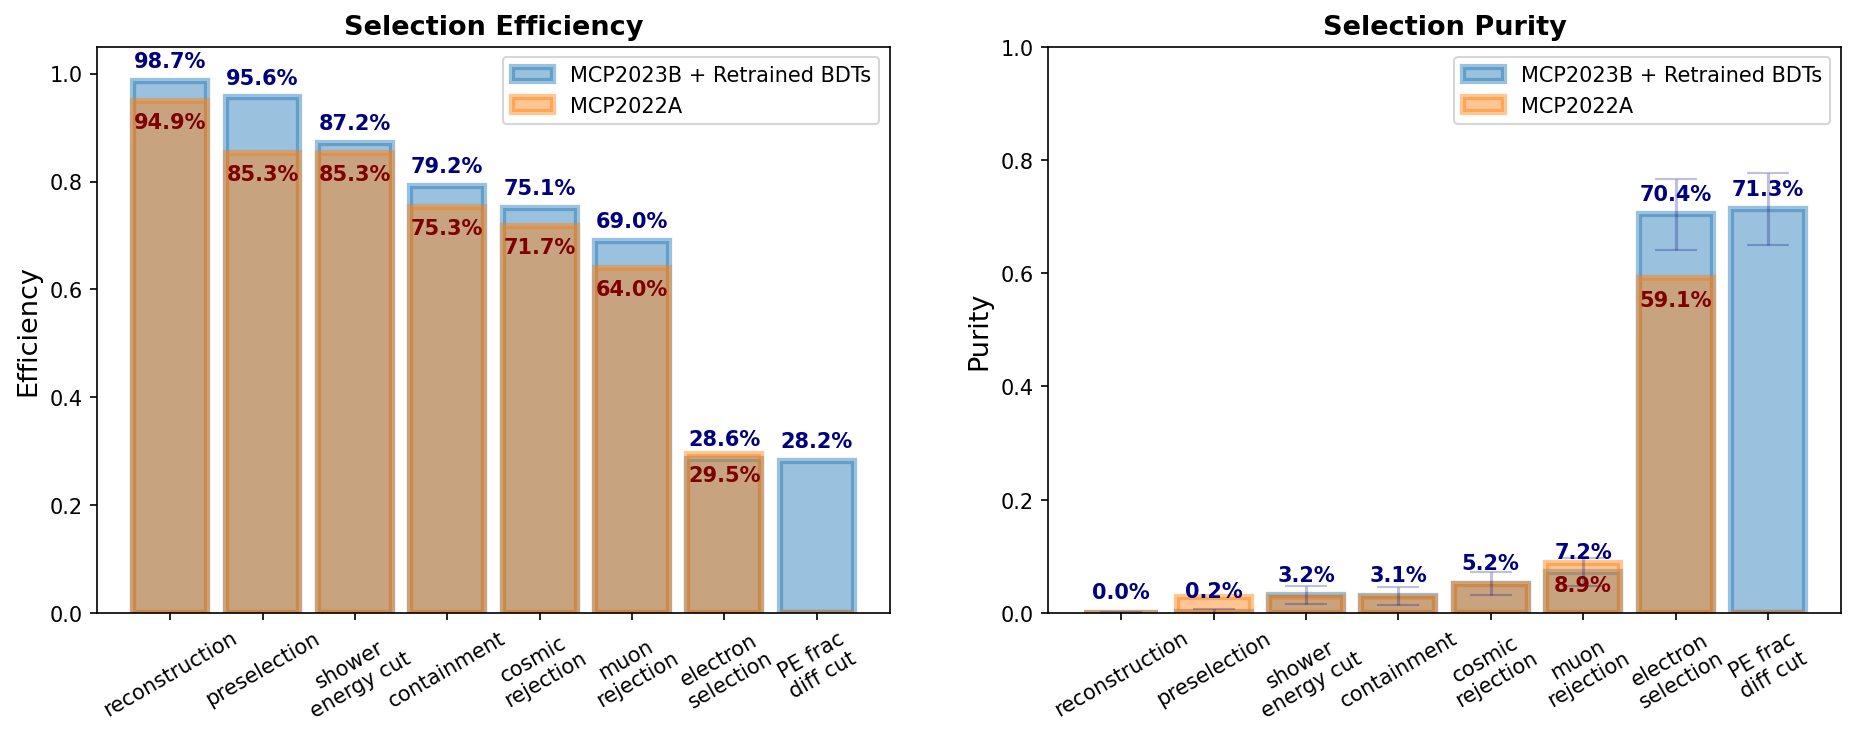

In [36]:
labels = ["preselection","shower\nenergy cut", "containment", "cosmic\nrejection", "muon\nrejection", "electron\nselection", "PE frac\ndiff cut"]

# purity and efficiency after each step
eff_den = len(nue.get_signal_evt(nue_nu_df)) # total number of signal events

keys = list(nue_df_dict.keys())
nue_df_list = [slc_ro_nue_nu_df] + [nue_df_dict[key] for key in keys]
bnb_df_list = [slc_ro_bnb_nu_df] + [bnb_df_dict[key] for key in keys]
int_df_list = [slc_ro_int_df]    + [int_df_dict[key] for key in keys]
stages = ["reconstruction"] + labels

eff_old = np.array([94.9, 85.3, 85.3, 75.3,71.7,64.0,29.5,0])*0.01
pur_old = np.array([0.003, 2.9,  2.9,  2.9, 5.1, 8.9,59.1,0])*0.01

eff = np.zeros(len(nue_df_list))
pur = np.zeros(len(nue_df_list))

pur_err = np.zeros(len(nue_df_list))

for i in range(0,len(nue_df_list)):
    nue_df = nue_df_list[i]
    bnb_df = bnb_df_list[i]
    int_df = int_df_list[i]
    
    pur_num = len(nue.get_signal_slc(nue_df))*nue.nue_scale
    pur_den = len(nue.get_slc(nue_df))*nue.nue_scale + len(nue.get_slc(bnb_df)) + len(nue.get_slc(int_df))*int_scale
    eff_num = len(nue.get_signal_evt(nue_df))
    
    eff_num_err = (np.sqrt(eff_num))
    eff_den_err = (np.sqrt(eff_den))

    sig = len(nue.get_signal_slc(nue_df))*nue.nue_scale    
    sig_err = np.sqrt(len(nue.get_signal_slc(nue_df)))*nue.nue_scale
    bkg = len(nue.get_slc(bnb_df)) + len(nue.get_slc(nue_df))*nue.nue_scale
    bkg_err = np.sqrt( len(nue.get_slc(bnb_df)) + ((len(nue.get_slc(nue_df)))*nue.nue_scale))
    
    pur_err[i] = ((bkg)/(bkg+sig))*np.sqrt( (bkg_err/bkg)**2 + (bkg_err**2 + sig_err**2)/((bkg + sig)**2))

    eff[i] = eff_num/eff_den
    pur[i] = pur_num/pur_den
    
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].bar(stages,eff,label="MCP2023B + Retrained BDTs",alpha=0.45,lw=3,edgecolor="C0")
axes[1].bar(stages,pur,label="MCP2023B + Retrained BDTs",alpha=0.45,lw=3,edgecolor="C0")
axes[0].set_title("Selection Efficiency",fontsize=13,fontweight="bold")
axes[1].set_title("Selection Purity",fontsize=13,fontweight="bold")
axes[0].set_ylabel("Efficiency",fontsize=13)
axes[1].set_ylabel("Purity",fontsize=13)

axes[0].bar(stages,eff_old, alpha = 0.45, edgecolor="C1", lw=3,label="MCP2022A")
axes[1].bar(stages,pur_old, alpha = 0.45, edgecolor="C1", lw=3,label="MCP2022A")
axes[1].errorbar(stages,pur,yerr=pur_err,fmt='none',ecolor="navy",capsize=10,alpha=0.25)

for i in range(len(stages)):
    above_offset = 0.025 
    below_offset = 0.05 
    new_val = eff[i]; old_val = eff_old[i]       
    axes[0].text(i, new_val+above_offset, str(round(new_val*100,1))+"%", ha='center',color="navy",fontweight="bold")
    if i!=(len(stages)-1):
        axes[0].text(i, old_val-below_offset, str(round(old_val*100,1))+"%", ha='center',color="maroon",fontweight="bold")
    
    new_val = pur[i]; old_val = pur_old[i]
    axes[1].text(i, new_val+above_offset, str(round(new_val*100,1))+"%", ha='center',color="navy",fontweight="bold")
    if ((i==5) | (i==6)):
        axes[1].text(i, old_val-below_offset, str(round(old_val*100,1))+"%", ha='center',color="maroon",fontweight="bold")
    
axes[0].legend()
axes[1].legend()
axes[1].set_ylim(0,1.0)
axes[0].set_ylim(0,1.05)

# rotate the labels on the x-axis
axes[0].set_xticks(range(len(stages))); axes[0].set_xticklabels(stages,rotation=30)
axes[1].set_xticks(range(len(stages))); axes[1].set_xticklabels(stages,rotation=30)

plt.show()

## Plots!

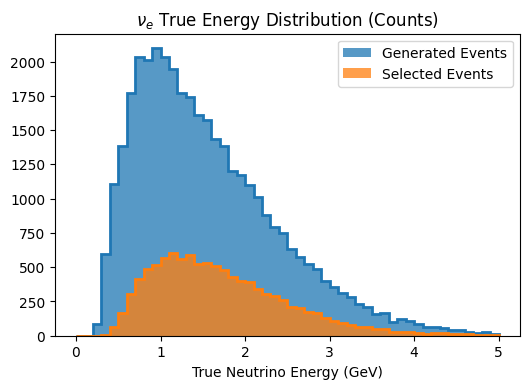

In [384]:
plt.figure(dpi=100)
bins=np.linspace(0,5,51)
plt.hist(nue_nu_df.query("signal==0").E,
         alpha=0.75,
         bins=bins,
         label="Generated Events")
plt.hist(nue_df_dict["PE Fractional Difference"].E,
         alpha=0.75,
         bins=bins,
         label="Selected Events")
plt.hist(nue_nu_df.query("signal==0").E,
         bins=bins,
         histtype="step",
         lw=2,
         color="C0")
plt.hist(nue_df_dict["PE Fractional Difference"].E,
         bins=bins,
         histtype="step",
         lw=2,
         color="C1")
plt.legend()
plt.title(r"$\nu_e$ True Energy Distribution (Counts)")
plt.xlabel("True Neutrino Energy (GeV)")
plt.show()

No handles with labels found to put in legend.


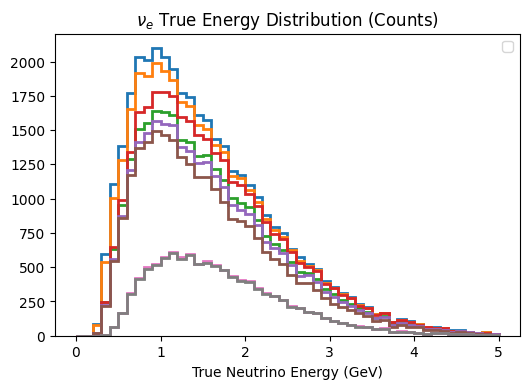

In [392]:
plt.figure(dpi=100)
bins=np.linspace(0,5,51)
plt.hist(nue_nu_df.query("signal==0").E,
         bins=bins,
         histtype="step",
         lw=2)
plt.hist(nue.get_signal_evt(nue_df_dict["preselection"]).E,
         bins=bins,
         histtype="step",
         lw=2)
plt.hist(nue.get_signal_evt(nue_df_dict["containment"]).E,
         bins=bins,
         histtype="step",
         lw=2)
plt.hist(nue.get_signal_evt(nue_df_dict["shw energy"]).E,
         bins=bins,
         histtype="step",
         lw=2)
plt.hist(nue.get_signal_evt(nue_df_dict["cosmic rejection"]).E,
         bins=bins,
         histtype="step",
         lw=2)
plt.hist(nue.get_signal_evt(nue_df_dict["muon rejection"]).E,
         bins=bins,
         histtype="step",
         lw=2)
plt.hist(nue.get_signal_evt(nue_df_dict["electron selection"]).E,
         bins=bins,
         histtype="step",
         lw=2)
plt.hist(nue.get_signal_evt(nue_df_dict["PE Fractional Difference"]).E,
         bins=bins,
         histtype="step",
         lw=2)
plt.legend()
plt.title(r"$\nu_e$ True Energy Distribution (Counts)")
plt.xlabel("True Neutrino Energy (GeV)")
plt.show()

No handles with labels found to put in legend.


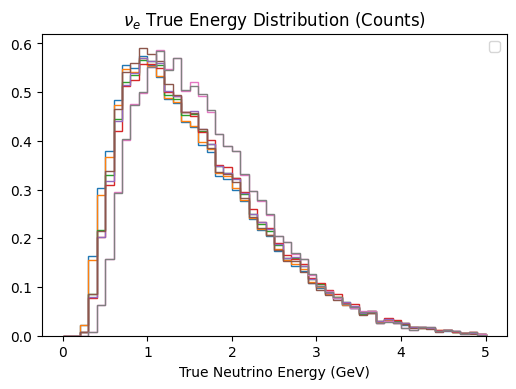

In [394]:
plt.figure(dpi=100)
bins=np.linspace(0,5,51)
plt.hist(nue_nu_df.query("signal==0").E,
         bins=bins,
         histtype="step",
         lw=1,
         density=True)
plt.hist(nue.get_signal_evt(nue_df_dict["preselection"]).E,
         bins=bins,
         histtype="step",
         lw=1,
         density=True)
plt.hist(nue.get_signal_evt(nue_df_dict["containment"]).E,
         bins=bins,
         histtype="step",
         lw=1,
         density=True)
plt.hist(nue.get_signal_evt(nue_df_dict["shw energy"]).E,
         bins=bins,
         histtype="step",
         lw=1,
         density=True)
plt.hist(nue.get_signal_evt(nue_df_dict["cosmic rejection"]).E,
         bins=bins,
         histtype="step",
         lw=1,
         density=True)
plt.hist(nue.get_signal_evt(nue_df_dict["muon rejection"]).E,
         bins=bins,
         histtype="step",
         lw=1,
         density=True)
plt.hist(nue.get_signal_evt(nue_df_dict["electron selection"]).E,
         bins=bins,
         histtype="step",
         lw=1,
         density=True)
plt.hist(nue.get_signal_evt(nue_df_dict["PE Fractional Difference"]).E,
         bins=bins,
         histtype="step",
         lw=1,
         density=True)
plt.legend()
plt.title(r"$\nu_e$ True Energy Distribution (Counts)")
plt.xlabel("True Neutrino Energy (GeV)")
plt.show()

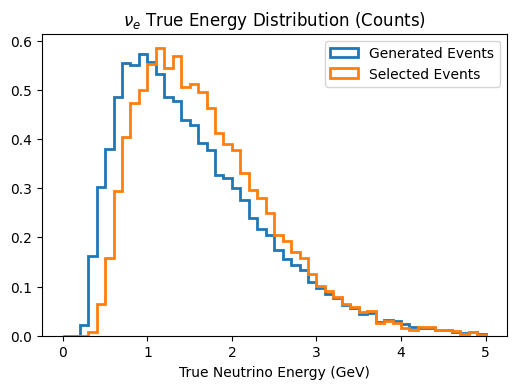

In [385]:
plt.figure(dpi=100)
bins=np.linspace(0,5,51)
plt.hist(nue_nu_df.query("signal==0").E,
         bins=bins,
         histtype="step",
         lw=2,
         color="C0",
         label="Generated Events",
         density=True)
plt.hist(nue_df_dict["PE Fractional Difference"].E,
         bins=bins,
         histtype="step",
         lw=2,
         color="C1",
         label="Selected Events",
         density=True)
plt.legend()
plt.title(r"$\nu_e$ True Energy Distribution (Counts)")
plt.xlabel("True Neutrino Energy (GeV)")
plt.show()

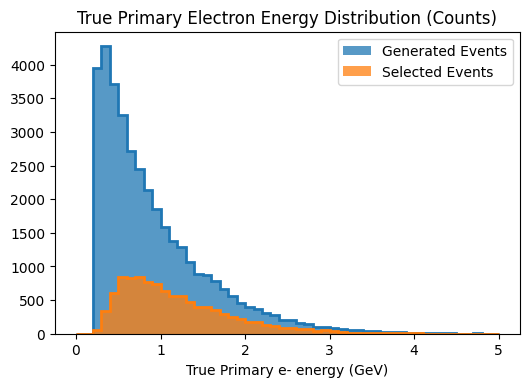

In [382]:
plt.figure(dpi=100)
bins=np.linspace(0,5,51)
plt.hist(nue_nu_df.query("signal==0").prim_startE - nue_nu_df.query("signal==0").prim_endE,
         alpha=0.75,
         bins=bins,
         label="Generated Events")
plt.hist(nue_df_dict["PE Fractional Difference"].prim_startE - nue_df_dict["PE Fractional Difference"].prim_endE,
         alpha=0.75,
         bins=bins,
         label="Selected Events")
plt.hist(nue_nu_df.query("signal==0").prim_startE - nue_nu_df.query("signal==0").prim_endE,
         bins=bins,
         histtype="step",
         lw=2,
         color="C0")
plt.hist(nue_df_dict["PE Fractional Difference"].prim_startE - nue_df_dict["PE Fractional Difference"].prim_endE,
         bins=bins,
         histtype="step",
         lw=2,
         color="C1")
plt.legend()
plt.title(r"True Primary Electron Energy Distribution (Counts)")
plt.xlabel("True Primary e- energy (GeV)")
plt.show()

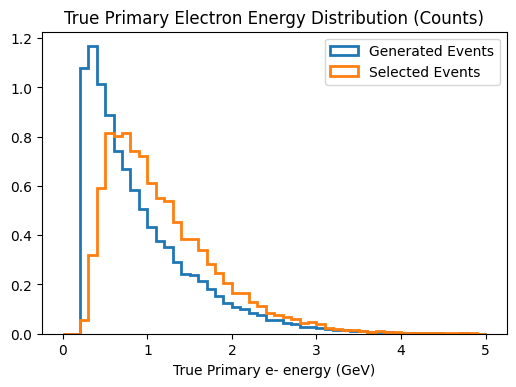

In [383]:
plt.figure(dpi=100)
bins=np.linspace(0,5,51)
plt.hist(nue_nu_df.query("signal==0").prim_startE - nue_nu_df.query("signal==0").prim_endE,
         bins=bins,
         histtype="step",
         lw=2,
         color="C0",
         density=True,
         label="Generated Events")
plt.hist(nue_df_dict["PE Fractional Difference"].prim_startE - nue_df_dict["PE Fractional Difference"].prim_endE,
         bins=bins,
         histtype="step",
         lw=2,
         color="C1",
         density=True,
         label="Selected Events")
plt.legend()
plt.title(r"True Primary Electron Energy Distribution (Counts)")
plt.xlabel("True Primary e- energy (GeV)")
plt.show()

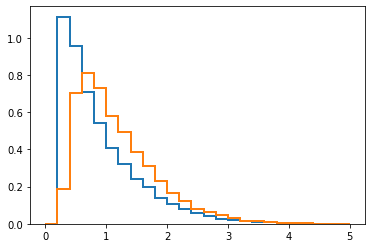

In [364]:
plt.hist(nue_nu_df.query("signal==0").prim_startE,
         bins=np.linspace(0,5,26),
         density=True,
         lw=2,
         histtype="step")
plt.hist(nue_df_dict["PE Fractional Difference"].prim_startE,
         bins=np.linspace(0,5,26),
         density=True,
         lw=2,
         histtype="step")
plt.show()

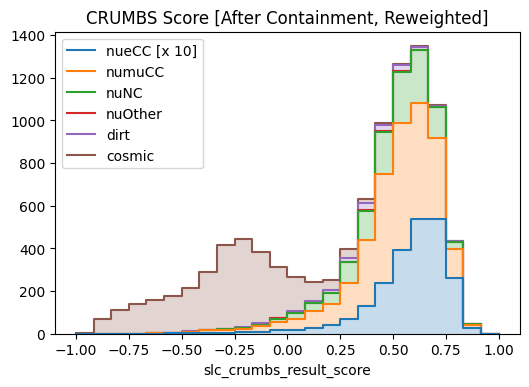

In [43]:
plt.figure(dpi=100)
nue.plot_var(df = [nue.get_slc(bnb_df_dict["containment"]),
                   nue.get_slc(nue_df_dict["containment"]),
                   nue.get_slc(int_df_dict["containment"])]
             ,scale = [1,nue.nue_scale,int_scale]
             ,var="slc_crumbs_result_score"
             ,stacked=True
             ,title="CRUMBS Score [After Containment, Reweighted]"
             ,mult_factor=10
             ,bins=np.linspace(-1,1,25))

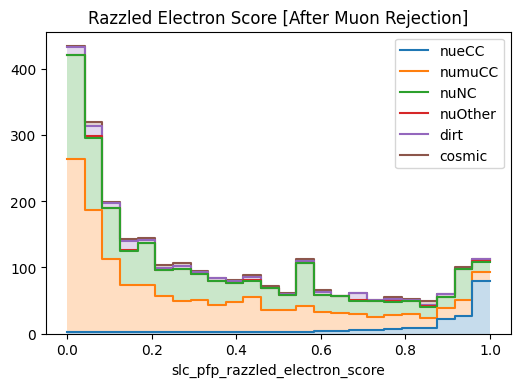

In [315]:
plt.figure(dpi=100)
nue.plot_var(df =      (bnb_df_dict["muon rejection"])
             ,df_add = (nue_df_dict["muon rejection"])
             ,var="slc_pfp_razzled_electron_score"
            #  ,label="Reco Primary Shower Energy [GeV]"
             ,stacked=True
             ,title="Razzled Electron Score [After Muon Rejection]"
            #  ,mult_factor=10
             ,bins=np.linspace(0,1.0,25))

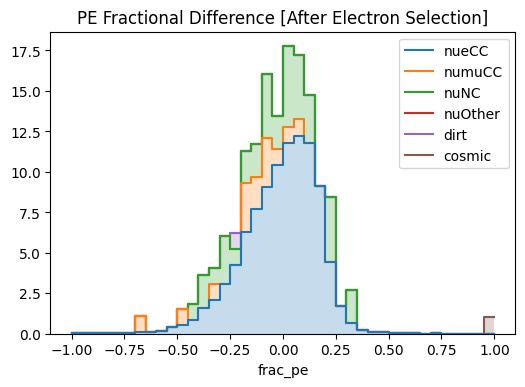

In [333]:
plt.figure(dpi=100)
nue.plot_var(df =      nue.get_slc(bnb_df_dict["electron selection"])
             ,df_add = nue.get_slc(nue_df_dict["electron selection"])
             ,title="PE Fractional Difference [After Electron Selection]"
             ,var="frac_pe"
             ,stacked=True
             ,bins=np.linspace(-1,1,41))

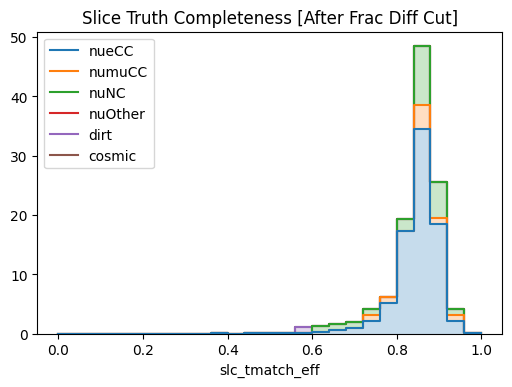

In [388]:
plt.figure(dpi=100)
nue.plot_var(df =      nue.get_slc(bnb_df_dict["PE Fractional Difference"])
             ,df_add = nue.get_slc(nue_df_dict["PE Fractional Difference"])
             ,title="Slice Truth Completeness [After Frac Diff Cut]"
             ,var="slc_tmatch_eff"
             ,stacked=True
             ,bins=np.linspace(0,1,26))

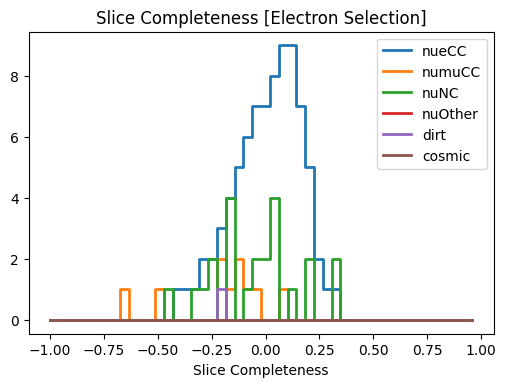

In [ ]:
plt.figure(dpi=100)
nue.plot_var(df=bnb_df_dict["electron selection"],
             df_add=nue_df_dict["electron selection"],
             var="frac_pe",
             bins=np.linspace(-1,1,50),
             title="Slice Completeness [Electron Selection]",
             label="Slice Completeness")